---
title: "Extracción de características radiómicas"
date: "2025-02-14"
categories: [Colab]
image: https://colab.research.google.com/img/colab_favicon_256px.png
---

Colab

<a href="https://colab.research.google.com/github/aotal/ImagenMedica/blob/master/posts/code/Radiomics_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este notebook, te mostraremos cómo extraer características en modo batch utilizando el enfoque de la interfaz de línea de comandos (cli).

Utilizaremos datos del repositorio https://github.com/rcuocolo/PROSTATEx_masks

Primero, necesitamos verificar e instalar las bibliotecas necesarias para realizar estos pasos más fácilmente.

In [1]:
!pip install --progress-bar off -q gdown
!pip install --upgrade --pre SimpleITK --find-links https://github.com/SimpleITK/SimpleITK/releases/tag/latest --progress-bar off -q
!pip install --progress-bar off -q matplotlib
!pip install --progress-bar off -q pyradiomics
!pip install --progress-bar off -q pyyaml
!pip install --progress-bar off -q pandas

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


## Importar librerías necesarias

In [2]:
import os
import pandas as pd
import csv
import yaml
import SimpleITK as sitk
import radiomics
import matplotlib.pyplot as plt
import gdown
import random
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact, fixed, Layout, Button, HBox
from IPython.display import display, clear_output

In [ ]:
# prompt: Montar mi unidad de google drive

from google.colab import drive
drive.mount('/content/drive')

# Descargar imágenes ProstateX y archivo de extracción de máscaras y parámetros

In [3]:
import os
if not os.path.isdir('input_t2w.csv'):
    !gdown 1dNqdVsN0PlCG01sl6wUCh9QJ5NnkOrDS -q
    !unzip lesions_T2.zip >/dev/null
    !rm lesions_T2.zip >/dev/null
    !rm -r __MACOSX >/dev/null
else:
    print("lesions_T2 folder already exists, the zip was not downloaded")

if not os.path.isfile('Params_T2_BW.yaml'):
    !gdown 12VOQCPFK4HARrwQzbB4fr_f2PepGPFWm -q
else:
    print("Params_T2_BW.yaml already exists, the file was not downloaded")

print('Done!')

Done!


Visualizar una imagen al azar y la máscara de la lesión

In [4]:
# Rutas a las carpetas (relativas para Colab)
ruta_imagenes = '/content/lesions_T2/Images'  # Usamos rutas relativas para Colab
ruta_mascaras = '/content/lesions_T2/Masks' # Usamos rutas relativas para colab

# Variables globales
pareja_actual = None
parejas_archivos = []
output_widget = widgets.Output()  # Widget de salida para mostrar las imágenes

def mostrar_imagen_y_mascara(ruta_imagen, ruta_mascara, zoom_x=0, zoom_y=0, zoom_size=50):
    """
    Muestra las tres imágenes (MRI, MRI+máscara, MRI+máscara con zoom).
    """
    try:
        imagen_sitk = sitk.ReadImage(ruta_imagen)
        mascara_sitk = sitk.ReadImage(ruta_mascara)
    except RuntimeError as e:
        print(f"Error al leer: {e}")
        return

    imagen_array = sitk.GetArrayFromImage(imagen_sitk)
    mascara_array = sitk.GetArrayFromImage(mascara_sitk)

    if imagen_array.shape != mascara_array.shape:
        if len(imagen_array.shape) == 3 and len(mascara_array.shape) == 4:
            if mascara_array.shape[3] == 1:
                mascara_array = np.squeeze(mascara_array, axis=3)
            else:
                print("Dimensiones incompatibles (4D).")
                return
        elif len(imagen_array.shape) != 3 or len(mascara_array.shape) != 3:
            print("Dimensiones incompatibles.")
            return

    cortes_con_lesion = np.where(np.any(mascara_array != 0, axis=(1, 2)))[0]
    if cortes_con_lesion.size == 0:
        print("No se encontraron cortes con lesión.")
        if len(imagen_array.shape) == 3:
            corte = random.randint(0, imagen_array.shape[0] - 1)
        else:
            imagen_slice = imagen_array
            mascara_slice = mascara_array
    else:
        corte = random.choice(cortes_con_lesion)

    if len(imagen_array.shape) == 3:
      imagen_slice = imagen_array[corte, :, :]
      mascara_slice = mascara_array[corte, :, :]

    # --- Preparación para el zoom ---
    zoom_x = max(zoom_size, min(zoom_x, imagen_slice.shape[1] - zoom_size - 1))
    zoom_y = max(zoom_size, min(zoom_y, imagen_slice.shape[0] - zoom_size - 1))
    fila_inicio = max(0, zoom_y - zoom_size)
    fila_fin = min(imagen_slice.shape[0], zoom_y + zoom_size)
    col_inicio = max(0, zoom_x - zoom_size)
    col_fin = min(imagen_slice.shape[1], zoom_x + zoom_size)
    imagen_zoom = imagen_slice[fila_inicio:fila_fin, col_inicio:col_fin]
    mascara_zoom = mascara_slice[fila_inicio:fila_fin, col_inicio:col_fin]
    mascara_zoom_rgba = np.zeros((mascara_zoom.shape[0], mascara_zoom.shape[1], 4))
    mascara_zoom_rgba[mascara_zoom != 0, :3] = plt.cm.jet(mascara_zoom[mascara_zoom != 0])[:, :3]
    mascara_zoom_rgba[mascara_zoom != 0, 3] = 0.5

    # --- Creación de la figura y subplots DENTRO del contexto del widget de salida ---
    with output_widget:
        clear_output(wait=True)  # Borrar la salida anterior
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # --- Mostrar imagen original (sin zoom) ---
        axes[0].imshow(imagen_slice, cmap='gray')
        axes[0].set_title(f'Imagen MRI (Corte: {corte})')
        axes[0].axis('off')

        # --- Mostrar imagen con máscara superpuesta (sin zoom) ---
        mascara_rgba = np.zeros((mascara_slice.shape[0], mascara_slice.shape[1], 4))
        mascara_rgba[mascara_slice != 0, :3] = plt.cm.jet(mascara_slice[mascara_slice != 0])[:, :3]
        mascara_rgba[mascara_slice != 0, 3] = 0.5
        axes[1].imshow(imagen_slice, cmap='gray')
        axes[1].imshow(mascara_rgba)
        axes[1].set_title(f'Máscara Superpuesta (Corte: {corte})')
        axes[1].axis('off')

        # --- Mostrar imagen con máscara superpuesta (zoom) ---
        axes[2].imshow(imagen_zoom, cmap='gray')
        axes[2].imshow(mascara_zoom_rgba)
        axes[2].set_title('Máscara Superpuesta (Zoom)')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()


def obtener_parejas_archivos(ruta_imagenes, ruta_mascaras):
    """Obtiene y empareja archivos."""
    imagenes = sorted([f for f in os.listdir(ruta_imagenes) if f.endswith('.nii.gz') and "ProstateX" in f])
    mascaras = sorted([f for f in os.listdir(ruta_mascaras) if f.endswith('.nii.gz') and "ProstateX" in f])
    parejas = []
    for img in imagenes:
        img_id = img.split('_')[0]
        for masc in mascaras:
            if img_id in masc:
                ruta_img = os.path.join(ruta_imagenes, img)
                ruta_masc = os.path.join(ruta_mascaras, masc)
                parejas.append((ruta_img, ruta_masc))
                break  # Importante: salir del bucle interno una vez encontrada la pareja
    return parejas



def actualizar_imagen(b):
    """Función para actualizar la imagen al hacer clic en el botón."""
    global pareja_actual, parejas_archivos
    if not parejas_archivos:
        parejas_archivos = obtener_parejas_archivos(ruta_imagenes, ruta_mascaras)
    pareja_actual = random.choice(parejas_archivos)
    imagen_sitk = sitk.ReadImage(pareja_actual[0])
    imagen_array = sitk.GetArrayFromImage(imagen_sitk)

    if len(imagen_array.shape) == 3:
        dim_x = imagen_array.shape[2]
        dim_y = imagen_array.shape[1]
    else:
        dim_x = imagen_array.shape[1]
        dim_y = imagen_array.shape[0]

    zoom_x_slider.max = dim_x - 1
    zoom_x_slider.value = dim_x // 2
    zoom_y_slider.max = dim_y - 1
    zoom_y_slider.value = dim_y // 2
    zoom_size_slider.max = min(dim_x, dim_y) // 2
    zoom_size_slider.value = 50

    mostrar_imagen_y_mascara(pareja_actual[0], pareja_actual[1],
                            zoom_x_slider.value, zoom_y_slider.value, zoom_size_slider.value)


# --- Configuración inicial ---
parejas_archivos = obtener_parejas_archivos(ruta_imagenes, ruta_mascaras)
if not parejas_archivos:
    print("No se encontraron parejas de archivos.")
    #Si no se encuentran parejas, no se puede continuar. Se podría poner un mensaje en un widget.
else:
    pareja_actual = random.choice(parejas_archivos)
    imagen_sitk_inicial = sitk.ReadImage(pareja_actual[0])
    imagen_array_inicial = sitk.GetArrayFromImage(imagen_sitk_inicial)

    if len(imagen_array_inicial.shape) == 3:
        dim_x = imagen_array_inicial.shape[2]
        dim_y = imagen_array_inicial.shape[1]
    else: #Si es 2D
        dim_x = imagen_array_inicial.shape[1]
        dim_y = imagen_array_inicial.shape[0]


    # --- Crear widgets ---
    zoom_x_slider = widgets.IntSlider(min=0, max=dim_x - 1, step=1, value=dim_x // 2, description='Zoom X', continuous_update=False, layout=Layout(width='50%'))
    zoom_y_slider = widgets.IntSlider(min=0, max=dim_y - 1, step=1, value=dim_y // 2, description='Zoom Y', continuous_update=False, layout=Layout(width='50%'))
    zoom_size_slider = widgets.IntSlider(min=10, max=min(dim_x,dim_y) // 2, step=1, value=50, description='Zoom Size', continuous_update=False, layout=Layout(width='50%'))
    boton_cambiar = Button(description="Cambiar Imagen")
    boton_cambiar.on_click(actualizar_imagen)

    # --- Configurar la interfaz ---
    ui = HBox([boton_cambiar, zoom_x_slider, zoom_y_slider, zoom_size_slider])
    # Ya no usamos interactive_output, sino el widget de salida directamente
    display(ui, output_widget)

    # Mostrar la imagen inicial
    mostrar_imagen_y_mascara(pareja_actual[0], pareja_actual[1],
                            zoom_x_slider.value, zoom_y_slider.value, zoom_size_slider.value)

Output()

### Veamos nuestro archivo de parámetros

Seleccione el icono de la carpeta en la barra de la izquierda y haga doble clic en Params_T2_BW.yaml para verlo.

#### Normalización
Dado que estamos trabajando con imágenes T2w MRI vamos a normalizar las imágenes utilizando el parámetro `normalize` que establecemos como `true`. Esto fija la intensidad media de las imágenes en cero y escala la desviación estándar para que sea igual a uno. A continuación escalamos la desviación estándar de las intensidades de las imágenes a 100 estableciendo `normalizeScale` en `true`.

El cálculo de algunas características (a saber, la energía, la energía total y RMS) se ve afectada por la existencia de valor negativo y ya que hemos normalizado nuestras imágenes para tener media 0 y desviación estándar de 100 tenemos que asegurarnos de que la mayoría de nuestras intensidades de imagen normalizada es igual o superior a 0. Podemos hacer esto usando el `voxelArrayShift`. Seleccionamos un valor de `300`, que asumiendo una distribución normal de las intensidades de la imagen aseguraría que el 99.7% de ellas están por encima de 0.

#### Ahorro de memoria
El valor `preCrop` ajustado a `true` nos permite ahorrar algo de memoria durante el cálculo de las características (y posiblemente evitar errores).

#### Tipo de extracción de características (2D vs 3D)
Tenemos un conjunto de datos en el que nuestras imágenes son anisótropas (las dimensiones de los vóxeles no son las mismas para los tres ejes) y, más concretamente, el grosor del corte es mucho mayor que la resolución en el plano. Debido a esto, realizaremos la extracción de características radiómicas 2D en lugar de 3D. Ya que nuestras imágenes son Axiales T2w, necesitamos definir que deseamos realizar una extracción de características 2D estableciendo `force2D` a `true` y estableciendo el eje en el plano a `0` usando `force2Ddimension` (Axial - 0, Coronal - 1, Sagital - 2).

#### Interpolación/Remuestreo
Para asegurar que estamos extrayendo características radiómicas que son comparables entre diferentes imágenes necesitamos estandarizar las dimensiones de los vóxeles en el plano. Hacemos esto ajustando el `interpolator` a `sitkBSpline` y el `resampledPixelSpacing` a una resolución elegida `[0.6, 0.6, 0]` (el 0 en la tercera posición significa que no remuestrearemos el grosor del corte y sólo la resolución en el plano de las imágenes será transformada a 0.6 mm x 0.6 mm, lo cual está bien porque las características serán extraídas en 2D).

#### Resegmentación
La resegmentación permite redefinir la máscara para, por ejemplo, descartar intensidades en nuestra máscara que estén fuera de $mean\ \pm\ 3\times std$. Podemos hacerlo ajustando `resegmentMode` a `sigma` y `resegmentRange` a `[-3, 3]`.

#### Discritización de la intensidad
Para asegurarnos de que el número de bins utilizados para la extracción de características está entre 30 y 130, realizamos una primera extracción de características para obtener el `original_firstorder_Range` de nuestros pacientes y seleccionamos el `binWidth` para que sea mayor que 30 y menor que 130 en todos los pacientes.

#### Filtros y características
Utilizamos `imageType` para definir los tipos de imágenes de las que queremos extraer las características radiómicas y `featureClass` para seleccionar el tipo de características a extraer.

# Realizar la extracción de características radiómicas - Crear el fichero de entrada

Para la extracción de características radiómicas utilizaremos el modo batch de PyRadiomics, donde tendremos que proporcionar como entrada el fichero `.csv` que contiene 3 columnas. La primera columna es el `ID`, la segunda la `Image` y la tercera la `Mask`, como se muestra a continuación.

In [5]:
if not os.path.isfile('input_t2w.csv'):
    dir_image_path = 'lesions_T2/Images'
    dir_mask_path = 'lesions_T2/Masks'

    img_files = sorted([os.path.join(dir_image_path, x) for x in os.listdir(dir_image_path) if '.nii' in x])
    msk_files = sorted([os.path.join(dir_mask_path, x) for x in os.listdir(dir_mask_path) if '.nii.gz' in x])

    input_csv_t2 = [["ID", "Image", "Mask"]]
    for msk_file in msk_files:
        patient_id = os.path.basename(msk_file)[:14]
        image = [x for x in img_files if patient_id in x][0]
        input_csv_t2.append([patient_id, image, msk_file])

    with open('input_t2w.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(input_csv_t2)

### Comprobar el fichero de entrada

In [6]:
input_df = pd.read_csv('input_t2w.csv')
input_df.head()

,ID,Image,Mask
0,ProstateX-0000,lesions_T2/Images/ProstateX-0000_t2_tse_tra_4....,lesions_T2/Masks/ProstateX-0000-Finding1-t2_ts...
1,ProstateX-0001,lesions_T2/Images/ProstateX-0001_t2_tse_tra_10...,lesions_T2/Masks/ProstateX-0001-Finding1-t2_ts...
2,ProstateX-0002,lesions_T2/Images/ProstateX-0002_t2_tse_tra_4....,lesions_T2/Masks/ProstateX-0002-Finding1-t2_ts...
3,ProstateX-0002,lesions_T2/Images/ProstateX-0002_t2_tse_tra_4....,lesions_T2/Masks/ProstateX-0002-Finding2-t2_ts...
4,ProstateX-0003,lesions_T2/Images/ProstateX-0003_t2_tse_tra_3....,lesions_T2/Masks/ProstateX-0003-Finding1-t2_ts...


In [7]:
# prompt: crear una tabla simplificada de input_df tomando solamente 20 registros al azar y guardarla como csv con el mismo formato que input_t2w.csv



# Lee el archivo CSV de entrada
input_df = pd.read_csv('input_t2w.csv')

# Muestra las primeras 5 filas del DataFrame para verificar
print(input_df.head())

# Selecciona 2 filas aleatorias
simplified_df = input_df.sample(n=2)

# Guarda el DataFrame simplificado como un nuevo archivo CSV
simplified_df.to_csv('simplified_input.csv', index=False) # index=False evita guardar el índice

print("Archivo 'simplified_input.csv' creado con éxito.")


               ID                                              Image  \
0  ProstateX-0000  lesions_T2/Images/ProstateX-0000_t2_tse_tra_4....   
1  ProstateX-0001  lesions_T2/Images/ProstateX-0001_t2_tse_tra_10...   
2  ProstateX-0002  lesions_T2/Images/ProstateX-0002_t2_tse_tra_4....   
3  ProstateX-0002  lesions_T2/Images/ProstateX-0002_t2_tse_tra_4....   
4  ProstateX-0003  lesions_T2/Images/ProstateX-0003_t2_tse_tra_3....   

                                                Mask  
0  lesions_T2/Masks/ProstateX-0000-Finding1-t2_ts...  
1  lesions_T2/Masks/ProstateX-0001-Finding1-t2_ts...  
2  lesions_T2/Masks/ProstateX-0002-Finding1-t2_ts...  
3  lesions_T2/Masks/ProstateX-0002-Finding2-t2_ts...  
4  lesions_T2/Masks/ProstateX-0003-Finding1-t2_ts...  
Archivo 'simplified_input.csv' creado con éxito.


# Entradas necesarias para la ejecución por lotes de PyRadiomics

Además del fichero de entrada tendremos que proporcionar la ruta del fichero de salida donde se guardarán los valores de las características de las diferentes imágenes (usar `-o` antes de indicar la ruta), definir que queremos la salida como un fichero csv añadiendo `-f csv`, y finalmente indicar la ruta del fichero de parámetros usando `-p`.

Nuestro comando tiene el siguiente aspecto

`pyradiomics input_t2w.csv -o output_t2w.csv -f csv -p Params_T2_BW.yaml`.

# Ejecutar la extracción por lotes de características radiómicas

Se aconseja ejecutar la siguiente línea en su terminal o línea de comandos para acelerar la extracción. Para ello, elimine el «!» inicial de la siguiente línea

In [8]:
#!pyradiomics input_t2w.csv -o output_t2w.csv -f csv -p Params_T2_BW.yaml
!pyradiomics simplified_input.csv -o output_t2w.csv -f csv -p Params_T2_BW.yaml


[2025-02-14 18:08:06] W: radiomics.glcm: GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
[2025-02-14 18:08:16] W: radiomics.glcm: GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
[2025-02-14 18:08:25] W: radiomics.glcm: GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
[2025-02-14 18:08:31] W: radiomics.glcm: GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
[2025-02-14 18:08:42] W: radiomics.glcm: GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
[2025-02-14 18:08:56] W: radiomics.glcm: GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
[2025-02-14 18:08:58] W: radiomics.glcm: GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
[2025-02-14 18:09:15] W: radiomics.glcm: GLCM is symmet

# Comprobemos el fichero de salida radiomics

Como se puede ver, contiene las mismas tres columnas (ID, Imagen, Máscara) de nuestra entrada, diez columnas que proporcionan información sobre las versiones, las propiedades de la imagen y los ajustes de extracción de características, seguidas de los valores de las características radiómicas extraídas.


Mounted at /content/drive


In [16]:
# prompt: Grabar el fichero en drive con la ruta output_file_path

import shutil

# ... (rest of your code)

# Assuming you have already mounted your Google Drive
repo_path = '/content/drive/MyDrive/radiomics/' # Replace with the correct path
output_file_path = os.path.join(repo_path, 'output_t2w.csv')

# Use shutil to copy the file. This is more robust than relying on shell commands.
try:
  shutil.copyfile('output_t2w.csv', output_file_path)
  print(f"File 'output_t2w.csv' copied successfully to {output_file_path}")
except FileNotFoundError:
  print("Error: 'output_t2w.csv' not found.  Ensure the radiomics extraction completed successfully.")
except Exception as e:
  print(f"An error occurred: {e}")


File 'output_t2w.csv' copied successfully to /content/drive/MyDrive/radiomics/output_t2w.csv


In [ ]:
radiomics_df = pd.read_csv('output_t2w.csv')
#radiomics_df.head()
radiomics_df

,ID,Image,Mask,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,...,exponential_gldm_GrayLevelNonUniformity,exponential_gldm_GrayLevelVariance,exponential_gldm_HighGrayLevelEmphasis,exponential_gldm_LargeDependenceEmphasis,exponential_gldm_LargeDependenceHighGrayLevelEmphasis,exponential_gldm_LargeDependenceLowGrayLevelEmphasis,exponential_gldm_LowGrayLevelEmphasis,exponential_gldm_SmallDependenceEmphasis,exponential_gldm_SmallDependenceHighGrayLevelEmphasis,exponential_gldm_SmallDependenceLowGrayLevelEmphasis
0,ProstateX-0003,/content/lesions_T2/Images/ProstateX-0003_t2_t...,/content/lesions_T2/Masks/ProstateX-0003-Findi...,v3.0.1,1.26.4,2.5.0.dev98,1.8.0,3.11.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [0.6, 2, 3]}...",...,338.653759,1.575982,13.370539,13.053151,134.196659,1.683951,0.123960,0.249880,5.008230,0.029433
1,ProstateX-0066,/content/lesions_T2/Images/ProstateX-0066_t2_t...,/content/lesions_T2/Masks/ProstateX-0066-Findi...,v3.0.1,1.26.4,2.5.0.dev98,1.8.0,3.11.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [0.6, 2, 3]}...",...,175.159806,10.652365,27.926150,16.549637,164.001211,2.852991,0.131945,0.276328,17.098851,0.021965
2,ProstateX-0088,/content/lesions_T2/Images/ProstateX-0088_t2_t...,/content/lesions_T2/Masks/ProstateX-0088-Findi...,v3.0.1,1.26.4,2.5.0.dev98,1.8.0,3.11.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [0.6, 2, 3]}...",...,231.770552,3.702005,12.991411,18.185276,125.550920,3.833904,0.202990,0.227619,6.980876,0.038320
3,ProstateX-0167,/content/lesions_T2/Images/ProstateX-0167_t2_t...,/content/lesions_T2/Masks/ProstateX-0167-Findi...,v3.0.1,1.26.4,2.5.0.dev98,1.8.0,3.11.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [0.6, 2, 3]}...",...,287.436902,2.465771,14.773716,16.890339,162.530026,2.453957,0.125676,0.222954,5.723176,0.024466
4,ProstateX-0199,/content/lesions_T2/Images/ProstateX-0199_t2_t...,/content/lesions_T2/Masks/ProstateX-0199-Findi...,v3.0.1,1.26.4,2.5.0.dev98,1.8.0,3.11.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [0.6, 2, 3]}...",...,1493.644164,1.290177,14.338071,17.922011,219.006395,1.954829,0.106592,0.190605,3.573299,0.020675
5,ProstateX-0178,/content/lesions_T2/Images/ProstateX-0178_t2_t...,/content/lesions_T2/Masks/ProstateX-0178-Findi...,v3.0.1,1.26.4,2.5.0.dev98,1.8.0,3.11.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [0.6, 2, 3]}...",...,76.790614,4.010087,14.519856,12.234657,98.245487,2.109815,0.152822,0.251489,7.953520,0.032145
6,ProstateX-0001,/content/lesions_T2/Images/ProstateX-0001_t2_t...,/content/lesions_T2/Masks/ProstateX-0001-Findi...,v3.0.1,1.26.4,2.5.0.dev98,1.8.0,3.11.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [0.6, 2, 3]}...",...,347.115830,0.215117,4.554054,44.243243,181.990347,11.644935,0.275914,0.062268,0.359134,0.021200
7,ProstateX-0177,/content/lesions_T2/Images/ProstateX-0177_t2_t...,/content/lesions_T2/Masks/ProstateX-0177-Findi...,v3.0.1,1.26.4,2.5.0.dev98,1.8.0,3.11.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [0.6, 2, 3]}...",...,18.500000,16.975713,68.801020,5.520408,215.362245,0.365061,0.057039,0.538366,49.163145,0.026799
8,ProstateX-0033,/content/lesions_T2/Images/ProstateX-0033_t2_t...,/content/lesions_T2/Masks/ProstateX-0033-Findi...,v3.0.1,1.26.4,2.5.0.dev98,1.8.0,3.11.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [0.6, 2, 3]}...",...,258.350367,29.581321,128.783298,5.030282,415.886208,0.188250,0.026039,0.527831,87.166395,0.010771
9,ProstateX-0082,/content/lesions_T2/Images/Prostate

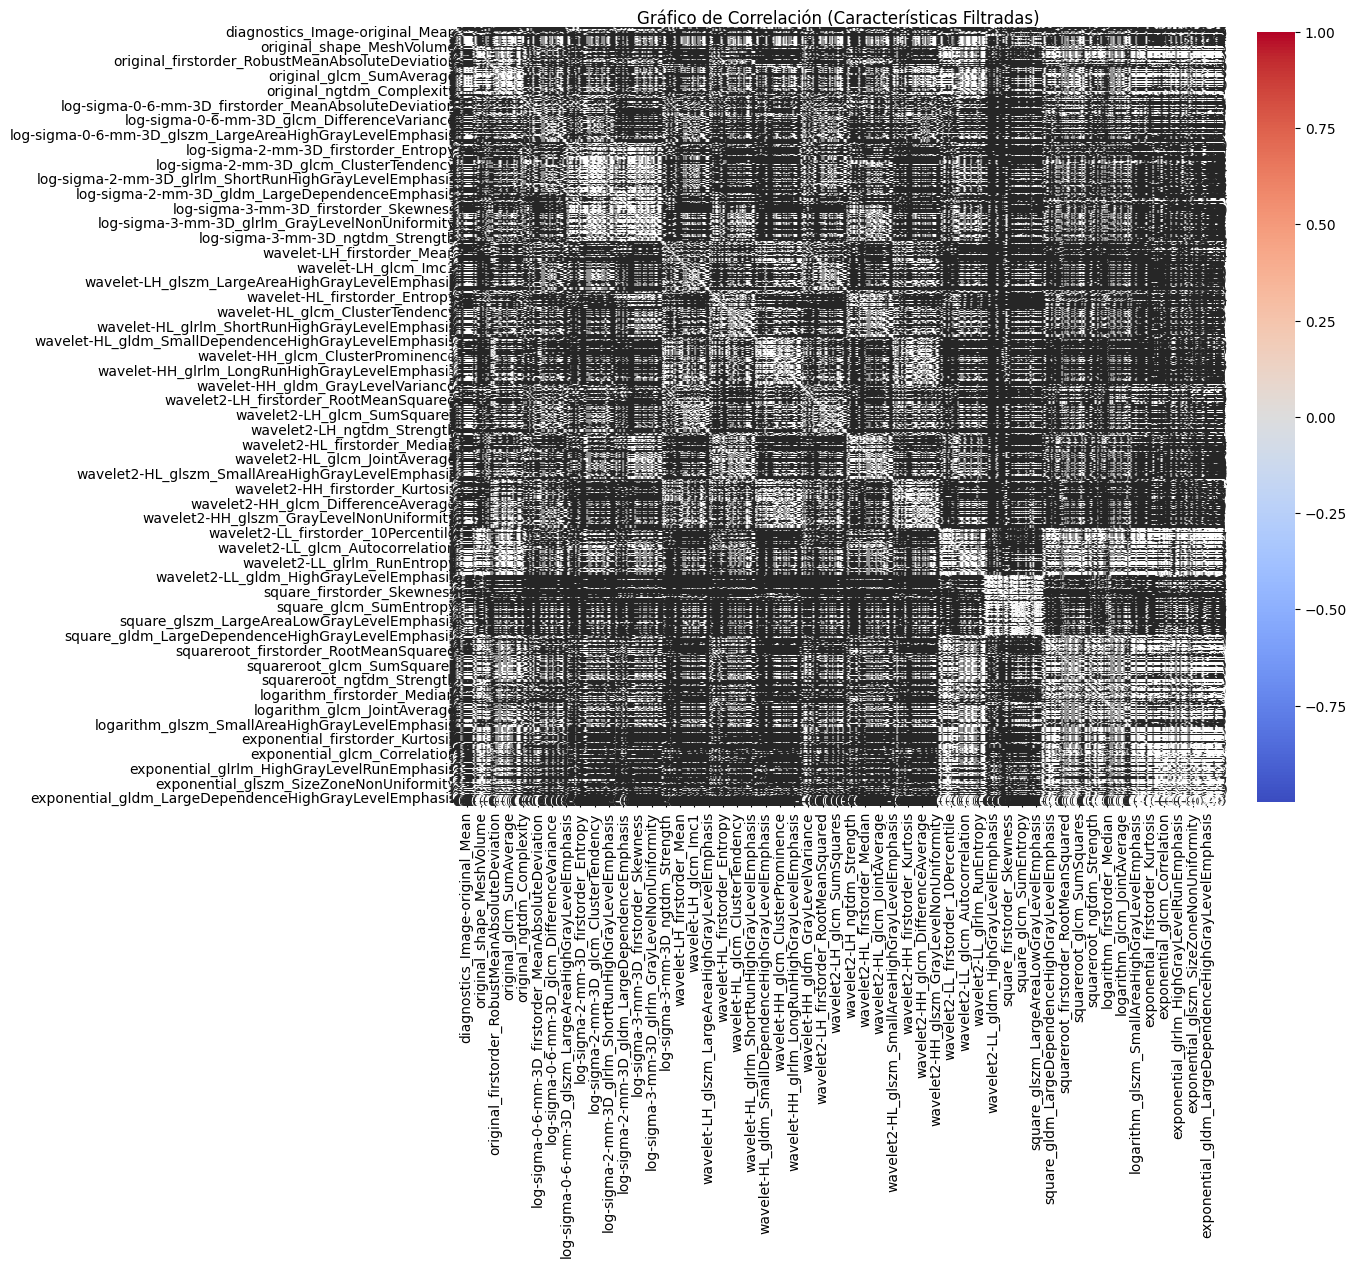

In [ ]:
# prompt: De la tabla anterior, hacer un gráfico de correlación de los valores que son numéricos

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold

radiomics_df = pd.read_csv('output_t2w.csv')

for col in radiomics_df.select_dtypes(include=['object']).columns:
    try:
        radiomics_df[col] = pd.to_numeric(radiomics_df[col], errors='coerce')
    except (ValueError, TypeError):
        pass

numeric_cols = radiomics_df.select_dtypes(include=['number']).dropna(axis=1, how='all')

if numeric_cols.empty:
    print("No numeric columns")
else:
    # --- Filtrado por varianza ---
    selector = VarianceThreshold(threshold=0.01)  # Elimina características con varianza < 0.01.  ¡Ajusta este umbral!
    selected_features = selector.fit_transform(numeric_cols)
    selected_cols = numeric_cols.columns[selector.get_support()]  # Obtiene los nombres de las columnas seleccionadas
    filtered_df = pd.DataFrame(selected_features, columns=selected_cols)

    # --- Ahora calcula la correlación y grafica SOLO con las características filtradas ---
    correlation_matrix = filtered_df.corr()
    plt.figure(figsize=(12, 10))  # Puedes ajustar el tamaño
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")  # Puedes probar con annot=False si sigue habiendo problemas
    plt.title('Gráfico de Correlación (Características Filtradas)')
    plt.show()